This code is for quick analysis of a heart sequence video. The aim is to:
- Identify problems
- Evaluate HRV
- Identify anomalies

We can evaluate HRV using the code we wrote previously to estimate HR over a single or three beats. This should (hopefully) average out any anomalies. It may also be worth writing code to estimate HR using the mean intensity as the optical-gating method fails when there is significant heart motion.

In [1]:
import optical_gating_analysis as OG
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Dataset settings
data_src = r"D:\Data\2012-06-20 13.34.11 vid 2x2 multi phase single plane\brightfield\*tif"
frame_rate = 80

In [3]:
def radsperframe_to_bps(radsperframe, framerate):
    return (radsperframe * framerate) / (2 * np.pi)

In [4]:
oog = OG.BasicOpticalGating()
oog.sequence_manager.set_source(data_src)
oog.run()

Setting source to D:\Data\2012-06-20 13.34.11 vid 2x2 multi phase single plane\brightfield\*tif
Getting reference sequence
Getting SADs
Getting phases


In [5]:
print(f"Reference period: ~{oog.sequence_manager.reference_period:.2f} frames")
print(f"Reference period: ~{oog.sequence_manager.reference_period / frame_rate:.2f} seconds")
print(f"Reference heartrate: ~{frame_rate / oog.sequence_manager.reference_period:.2f} beats per second")

Reference period: ~35.72 frames
Reference period: ~0.45 seconds
Reference heartrate: ~2.24 beats per second


# OOG outputs

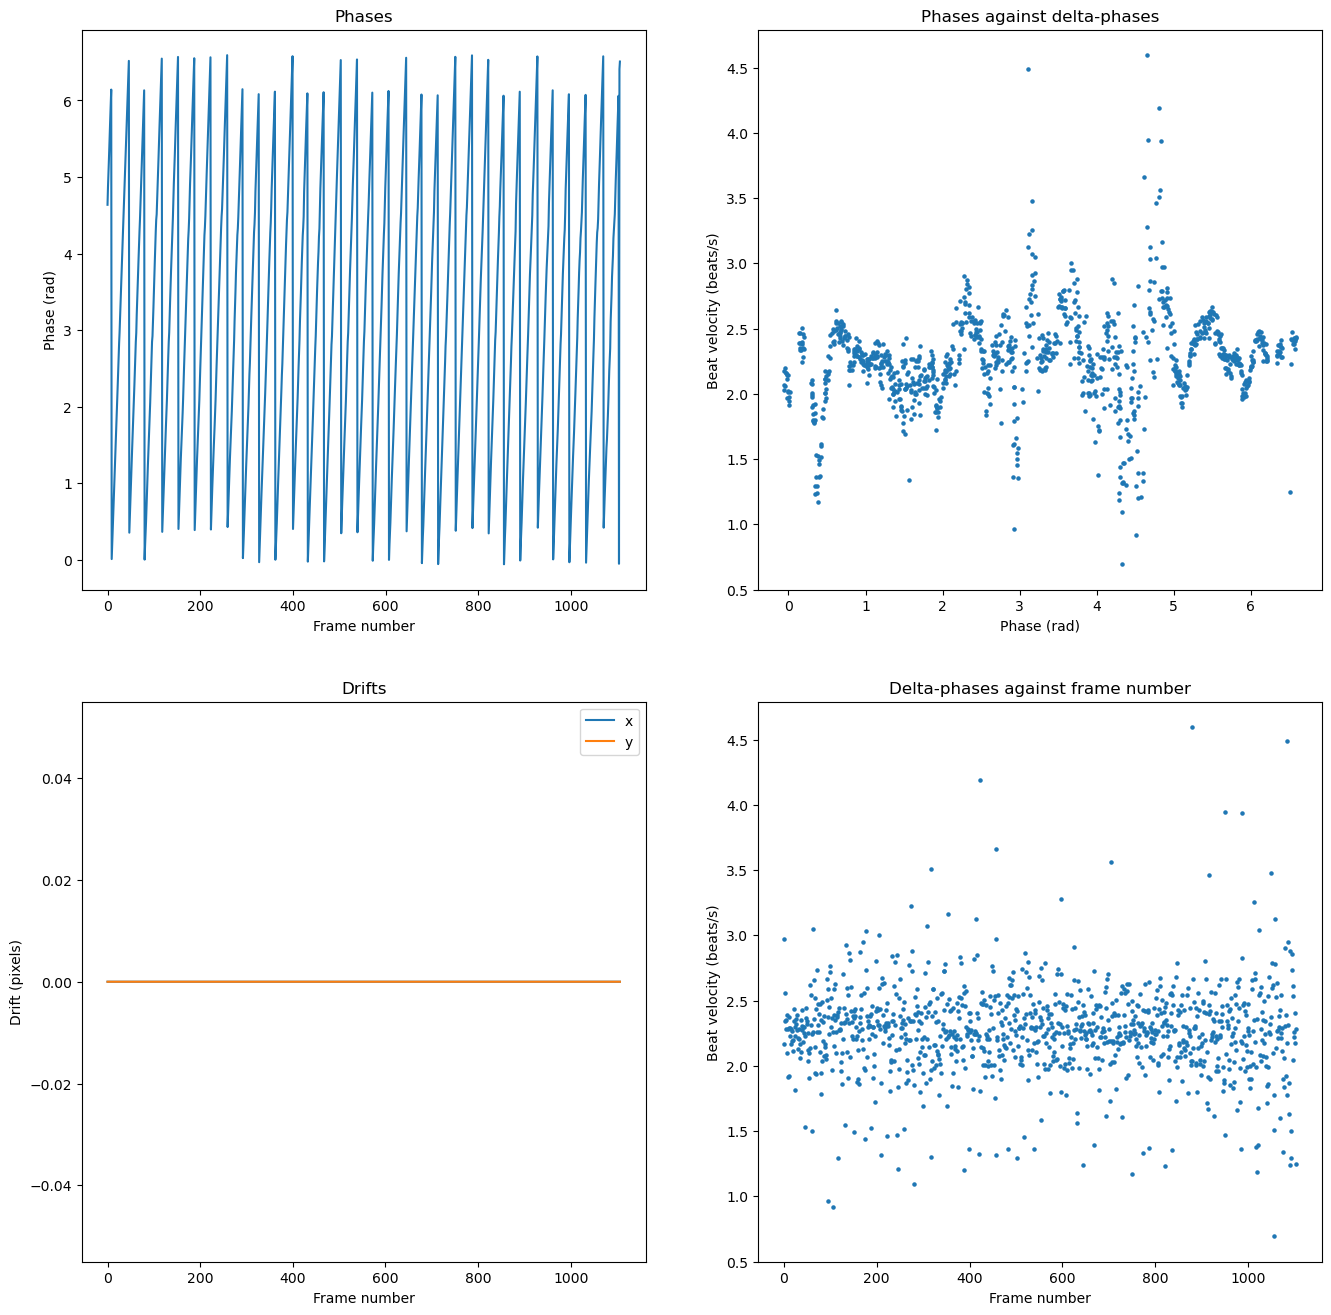

In [6]:
plt.figure(figsize = (16,16))
plt.subplot(221)
plt.title("Phases")
plt.plot(oog.phases)
plt.xlabel("Frame number")
plt.ylabel("Phase (rad)")

plt.subplot(222)
plt.title("Phases against delta-phases")
plt.scatter(oog.phases[1::],radsperframe_to_bps(oog.delta_phases, frame_rate), s = 5)
plt.xlabel("Phase (rad)")
plt.ylabel("Beat velocity (beats/s)")

plt.subplot(223)
plt.title("Drifts")
plt.plot(np.array(oog.drifts)[:,0], label = "x")
plt.plot(np.array(oog.drifts)[:,1], label = "y")
plt.legend()
plt.xlabel("Frame number")
plt.ylabel("Drift (pixels)")

plt.subplot(224)
plt.title("Delta-phases against frame number")
plt.scatter(range(oog.delta_phases.shape[0]), radsperframe_to_bps(oog.delta_phases, frame_rate), s = 5)
plt.xlabel("Frame number")
plt.ylabel("Beat velocity (beats/s)")

plt.show()

# Average HR

In [7]:
sadsmin = []
for i in range(len(oog.sads)):
    sadsmin.append(np.min(oog.sads[i]))

In [8]:
phases = oog.phases
unwrapped_phases = oog.unwrapped_phases

i_prev = 0
beat_indices = []
for i in range(1, phases.shape[0]):
    if (phases[i] - phases[i - 1]) < -np.pi:
        if abs(i_prev - i) > oog.sequence_manager.reference_period / 2:
            beat_indices.append(i)
            i_prev = i

gradients = []
from scipy.optimize import curve_fit
for i in range(len(beat_indices) - 2):
    xs = range(beat_indices[i], beat_indices[i+2])
    ys = unwrapped_phases[beat_indices[i]:beat_indices[i+2]]
    popt, popc = curve_fit(lambda x, a, b: a * x + b, xs, ys)
    gradients.append(popt[0])

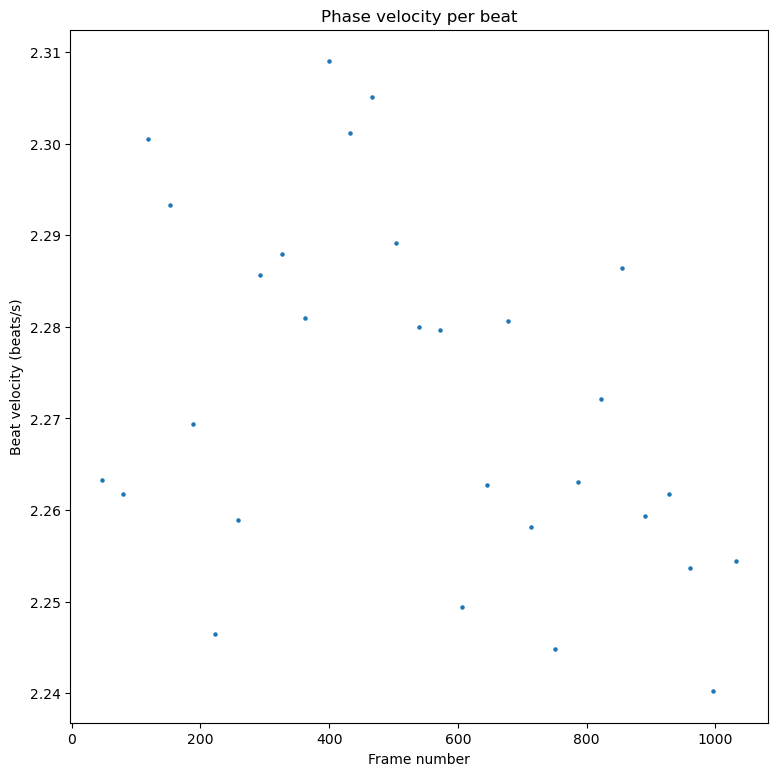

In [9]:
plt.figure(figsize = (9,9))
plt.title("Phase velocity per beat")
plt.scatter(np.array(beat_indices[:-2]), radsperframe_to_bps(np.array(gradients), frame_rate), s = 5)
plt.xlabel("Frame number")
plt.ylabel("Beat velocity (beats/s)")
plt.show()

# Poincaré Plot

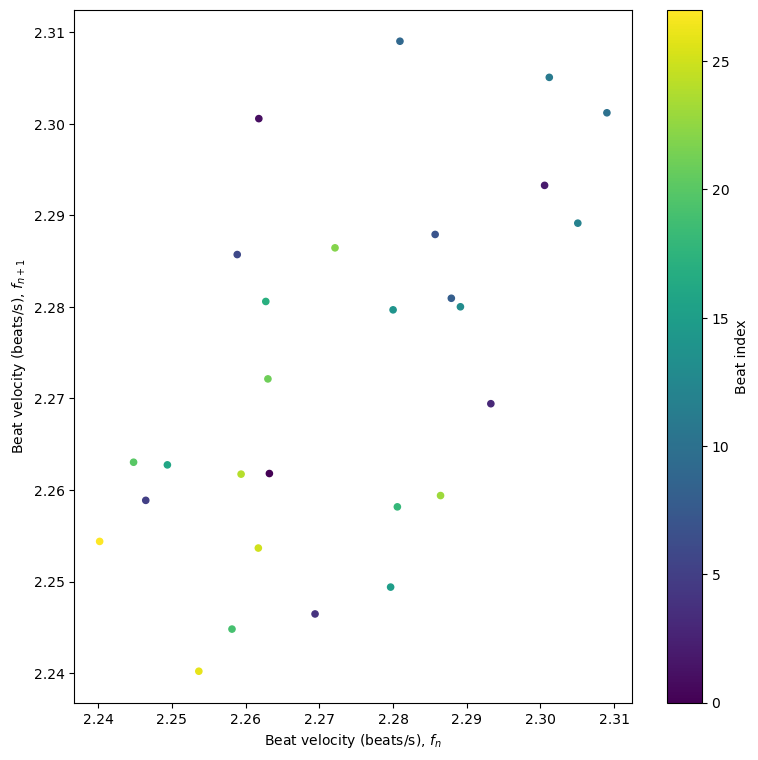

In [10]:
plt.figure(figsize=(9,9))
plt.scatter(radsperframe_to_bps(np.array(gradients[:-1]), frame_rate), radsperframe_to_bps(np.array(gradients[1:]), frame_rate), s = 20, c = range(len(gradients) - 1))
plt.colorbar(label = "Beat index")
plt.xlabel("Beat velocity (beats/s), $f_n$")
plt.ylabel("Beat velocity (beats/s), $f_{n+1}$")
plt.show()

# HRV metrics
RMSSD

In [21]:
# RMSSD
RR_interval = 60*1000/((radsperframe_to_bps(np.array(gradients), frame_rate) * 60))
RMSSD = np.sqrt(np.mean(np.diff(RR_interval)) ** 2)
print(f"RMSSD: {RMSSD*1000:.5f} ms")

RMSSD: 61.93137 ms
